# Homogenize for representative N4 in slices of parameter space

In [1]:
import planarfibers
import matplotlib.pyplot as plt
import pandas as pd
import vofotensors
from vofotensors.abc import la1, d1, d8
import sympy as sp
import numpy as np

In [2]:
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 1000)

In [3]:
# User input
SCALE_HOMOGENEOUS = False
key_quantity = "E_modulus"
homogenization_function = planarfibers.approximation.calc_MTOA
la1_values = ["3 / 6", "4 / 6", "5 / 6"]

In [4]:
# Get points on views
df = planarfibers.discretization.get_points_on_slices(
    radii=["0", "1/2", "9/10"],
    la1s=list(map(eval, la1_values)) + ["1"],
    numeric=True,
)

In [5]:
# Get fiber orientation tensors
parameterizations = vofotensors.fabric_tensors.N4s_parametric
parameterization = parameterizations["planar"]["la1_d1_d8"]
N4_func = sp.lambdify([la1, d1, d8], parameterization)
df["N4"] = df.apply(
    lambda row: N4_func(la1=row["la1"], d1=row["d_1"], d8=row["d_8"]), axis=1
)

In [6]:
# Define angle discretization
angles = np.linspace(0, 2 * np.pi, 120)

In [7]:
# Homogenize
df["stiffness"] = df.apply(
    lambda row: homogenization_function(N4=row["N4"], inp=None),
    axis=1,
)

In [8]:
# Define helper func to explicitly select either Youngs or generalized compression mod.
def get_Youngs_modulus(stiffness, angles):
    projector = planarfibers.utils.PlanarStiffnesProjector()
    E, K = projector.get_planar_E_K(stiffness=stiffness, angles=angles)
    if key_quantity == "E_modulus":
        return E
    elif key_quantity == "K_modulus":
        return K

In [9]:
# Get Youngs-Modulus for direction in plane
df[key_quantity] = df.apply(
    lambda row: get_Youngs_modulus(stiffness=row["stiffness"], angles=angles),
    axis=1,
)

In [10]:
# Define layout
la1_key_extensions = {f"-la1-{index}": value for index, value in enumerate(la1_values)}
# la1_key_extensions = {
# "-la1-0": "3 / 6",
# "-la1-1": "4 / 6",
# "-la1-2": "5 / 6",
# }
grid_indices = {
    "vshc-central": (2, 0),
    "vshc-m90-0": (3, 0),
    "vshc-m90-1": (4, 0),
    "vshc-m45-0": (3, 1),
    "vshc-m45-1": (4, 2),
    "vshc-0-0": (2, 1),
    "vshc-0-1": (2, 2),
    "vshc-45-0": (1, 1),
    "vshc-45-1": (0, 2),
    "vshc-90-0": (1, 0),
    "vshc-90-1": (0, 0),
}
legend_axis_indices = (4, 1)
empty_axes_indices = [(0, 1), (1, 2), (3, 2), legend_axis_indices]

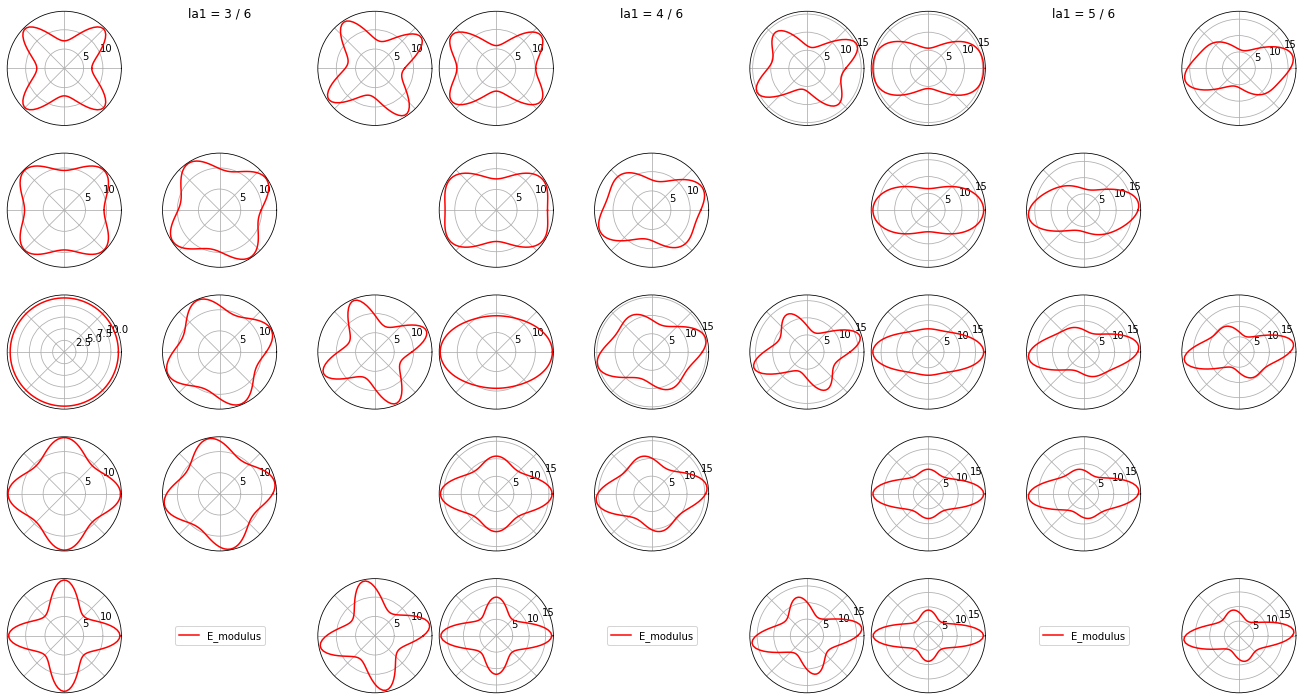

In [11]:
# Plot first view
nbr_slices = len(la1_key_extensions)
fig = plt.figure(figsize=(6 * nbr_slices, 10))
subfigs = fig.subfigures(1, nbr_slices, wspace=0.0)
for index, (key_extension, la1val) in enumerate(la1_key_extensions.items()):
    subfig = subfigs[index]
    subfig.suptitle(f"la1 = {la1val}")
    axs = subfig.subplots(ncols=3, nrows=5, subplot_kw={"projection": "polar"})
    lines = []  # Initialize legend lines
    for key_N4_start, grid_index in grid_indices.items():
        ax = axs[grid_index]
        key = key_N4_start + key_extension

        ax.plot(angles, df.loc[key][key_quantity], label=key_quantity, color="red")

        # Update legend if something has been plotted
        lines_tmp, labels_tmp = ax.get_legend_handles_labels()
        if len(lines_tmp) > len(lines):
            lines, labels = lines_tmp, labels_tmp

    for ax in axs.flatten():
        ax.set_xticklabels([])
        if SCALE_HOMOGENEOUS:
            ax.set_ylim(
                bottom=0,
                top=1.2,
            )
            ax.set_yticks([0, 0.5, 1])

    legend_axis = axs[legend_axis_indices]
    legend_axis.legend(lines, labels, loc="center")

    for indice in empty_axes_indices:
        ax = axs[indice]
        ax.axis("off")
fig.tight_layout()

In [12]:
# Define layout second view
grid_indices = {
    "v00-upper-0": (0, 0),
    "v00-upper-1": (0, 1),
    "v00-upper-2": (0, 2),
    #
    "v00-mid-0": (1, 0),
    "v00-mid-1": (1, 1),
    "v00-mid-2": (1, 2),
    #
    "v00-lower-0": (2, 0),
    "v00-lower-1": (2, 1),
    "v00-lower-2": (2, 2),
    #
    "v00-mid-3": (1, 3),
    #
}
legend_axis_indices = (0, 3)
empty_axes_indices = [(2, 3), legend_axis_indices]

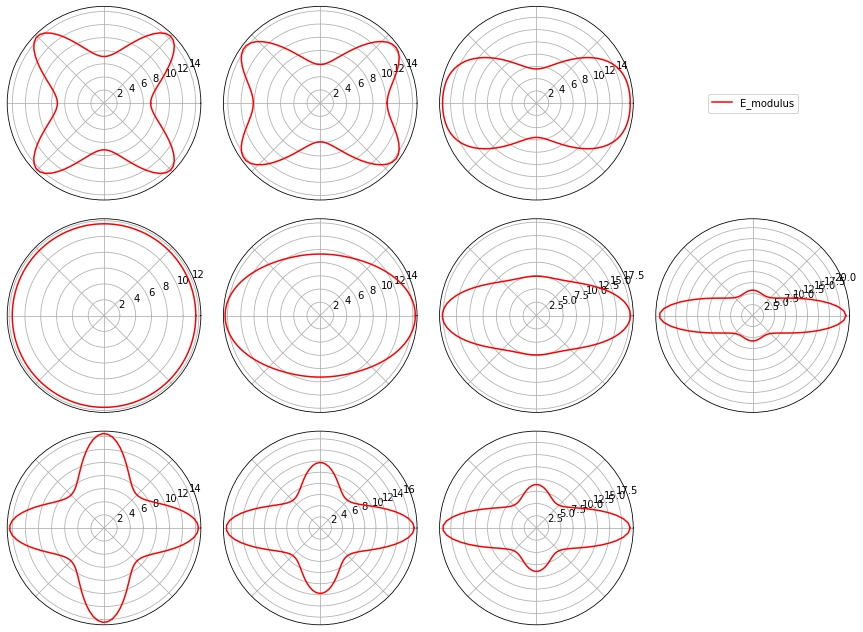

In [13]:
# Plot second dview
fig, axs = plt.subplots(
    figsize=(12, 9), ncols=4, nrows=3, subplot_kw={"projection": "polar"}
)
lines = []  # Initialize legend lines
for key_N4_start, grid_index in grid_indices.items():
    ax = axs[grid_index]
    key = key_N4_start

    ax.plot(angles, df.loc[key][key_quantity], label=key_quantity, color="red")

    # Update legend if something has been plotted
    lines_tmp, labels_tmp = ax.get_legend_handles_labels()
    if len(lines_tmp) > len(lines):
        lines, labels = lines_tmp, labels_tmp
for ax in axs.flatten():
    ax.set_xticklabels([])
    if SCALE_HOMOGENEOUS:
        ax.set_ylim(
            bottom=0,
            top=1.2,
        )
        ax.set_yticks([0, 0.5, 1])
legend_axis = axs[legend_axis_indices]
legend_axis.legend(lines, labels, loc="center")
for indice in empty_axes_indices:
    ax = axs[indice]
    ax.axis("off")
fig.tight_layout()

plt.show()